# Step [1]: Prepare libraries and data
### [1.1] Include important libraries

In [9]:
import nltk
import re
import heapq  
import pickle
import pandas as pd
import numpy as np
from string import punctuation
from nltk.corpus import stopwords
punctuation = punctuation + '\n'
from nltk.stem.isri import ISRIStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier

### [1.2] Text categories:

In [10]:
categories = ['Economy & Business', 'Diverse News', 'Politic', 'Sport', 'Technology','Entertainment']

### [1.3] Building the summerizer:

In [11]:
def nltk_summarizer(input_text, number_of_sentence):
    stopWords = set(nltk.corpus.stopwords.words("arabic") + nltk.corpus.stopwords.words("english"))
    word_frequencies = {}  
    for word in nltk.word_tokenize(input_text):  
        if word not in stopWords:
            if word not in punctuation:
                if word not in word_frequencies.keys():
                    word_frequencies[word] = 1
                else:
                    word_frequencies[word] += 1

    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():  
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)

    sentence_list = nltk.sent_tokenize(input_text)
    sentence_scores = {}  
    for sent in sentence_list:  
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]

    summary_sentences = heapq.nlargest(number_of_sentence, sentence_scores, key=sentence_scores.get)

    summary = ' '.join(summary_sentences)  
    return summary

### [1.4] Reading dataset file:

In [12]:
en_data = pd.read_csv('bbc_news_dataset.csv')
en_data = en_data.replace("entertainment", "Entertainment")
en_data = en_data.replace("business", "economy & business")
en_data['Category_Encoded'] = en_data['Category'].factorize()[0]


In [13]:
en_data.rename(columns = {'Category Encoded':'Category_Encoded'}, inplace = True)
en_data.columns
en_data.sample(10)

,ArticleId,Text,Category,Category_Encoded
1046,517,labour mp praises tory campaign the conservati...,politics,2
136,749,tv debate urged for party chiefs broadcasters ...,politics,2
1064,2075,apple sues tiger file sharers apple has take...,tech,1
1162,1913,elvis fans hold birthday bash elvis fans aroun...,Entertainment,4
896,978,jones happy with henson heroics wales fly-half...,sport,3
834,327,consumers drive french economy france s econom...,economy & business,0
1228,649,robots march to us cinema summit animated movi...,Entertainment,4
1067,1337,west end to honour finest shows the west end i...,Entertainment,4
822,426,england coach faces rap after row england coac...,sport,3
158,844,france starts digital terrestrial france has b...,tech,1


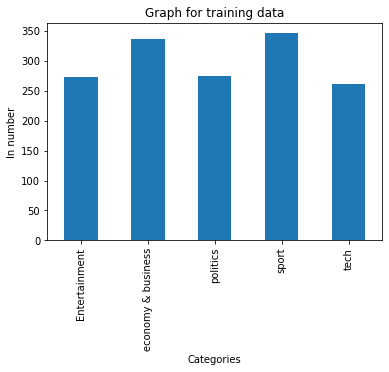

In [14]:
import matplotlib.pyplot as plt



en_data.groupby('Category').Category_Encoded.count().plot.bar(ylim=0)
plt.xlabel("Categories")
plt.ylabel("In number")
plt.title("Graph for training data")
plt.show()

# Step [2]: Data sterilization
### [2.1] Delete links:
This will remove all links from the text and it's include the following:
- Matches http protocols like [**http:// or https://**].
- Match optional whitespaces after http protocols.
- Optionally matches including the [**www.**] or not.
- Optionally matches whitespaces in the links.
- Matches 0 or more of one or more word characters followed by a period.
- Matches 0 or more of one or more words (or a dash or a space) followed by [**\\**].
- Any remaining path at the end of the url followed by an optional ending.
- Matches ending query params (even with white spaces, etc).

In [15]:
def delete_links(input_text):
    pettern  = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    out_text = re.sub(pettern, ' ', input_text)
    return out_text

### [2.2] Fixing word lengthening:
Word lengthening occurs when characters are wrongly repeated. English words have a max of two repeated characters like the words [**wood, school**]. Additional characters need to ripped off, otherwise we might add misleading information.

In [16]:
def delete_repeated_characters(input_text):
    pattern  = r'(.)\1{2,}'
    out_text = re.sub(pattern, r"\1\1", input_text)
    return out_text

In [17]:
def replace_letters(input_text):
    replace = {"أ": "ا","ة": "ه","إ": "ا","آ": "ا","": ""}
    replace = dict((re.escape(k), v) for k, v in replace.items()) 
    pattern = re.compile("|".join(replace.keys()))
    out_text = pattern.sub(lambda m: replace[re.escape(m.group(0))], input_text)
    return out_text

### [2.3] Delete bad symbols:
This method removes unwanted characters from the text, such as question marks, commas, star, plus ...etc.

In [18]:
def clean_text(input_text):
    replace = r'[/(){}\[\]|@âÂ,;\?\'\"\*…؟–’،!&\+-:؛-]'
    out_text = re.sub(replace, " ", input_text)
    words = nltk.word_tokenize(out_text)
    words = [word for word in words if word.isalpha()]
    out_text = ' '.join(words)
    return out_text

In [19]:
def remove_vowelization(input_text):
    vowelization = re.compile(""" ّ|َ|ً|ُ|ٌ|ِ|ٍ|ْ|ـ""", re.VERBOSE)
    out_text = re.sub(vowelization, '', input_text)
    return out_text

### [2.4] Delete stopwords:
Like prepositions and hyphens words. for example [**and, in, or ...etc**].

In [20]:
def delete_stopwords(input_text):
    stop_words = set(nltk.corpus.stopwords.words("arabic") + nltk.corpus.stopwords.words("english"))
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    tokens = tokenizer.tokenize(input_text)
    wnl = nltk.WordNetLemmatizer()
    lemmatizedTokens =[wnl.lemmatize(t) for t in tokens]
    out_text = [w for w in lemmatizedTokens if not w in stop_words]
    out_text = ' '.join(out_text)
    return out_text

In [21]:
def stem_text(input_text):
    st = ISRIStemmer()
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    tokens = tokenizer.tokenize(input_text)
    out_text = [st.stem(w) for w in tokens]
    out_text = ' '.join(out_text)
    return out_text

### [2.5] Text prepare:
- Applay all previus functions to sterilize the input text.
- Convert letters to lowercase to make all words in the text in the same letters sensitivity.

In [22]:
def text_prepare(input_text, ar_text):
    out_text = delete_links(input_text)
    out_text = delete_repeated_characters(out_text)
    out_text = clean_text(out_text)
    out_text = delete_stopwords(out_text)
    if ar_text:
        out_text = replace_letters(out_text)
        out_text = remove_vowelization(out_text)
        out_text = stem_text(out_text)
    else:
        out_text = out_text.lower()
    return out_text

In [23]:
import nltk

nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Sravya\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\Sravya\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Sravya\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\Sravya\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\Sravya\AppData\Roaming\nltk_data...
[nltk_data] 

[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package mte_teip5 to
[nltk_data]    |     C:\Users\Sravya\AppData\Roaming\nltk_data...
[nltk_data]    |   Package mte_teip5 is already up-to-date!
[nltk_data]    | Downloading package mwa_ppdb to
[nltk_data]    |     C:\Users\Sravya\AppData\Roaming\nltk_data...
[nltk_data]    |   Package mwa_ppdb is already up-to-date!
[nltk_data]    | Downloading package names to
[nltk_data]    |     C:\Users\Sravya\AppData\Roaming\nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Downloading package nombank.1.0 to
[nltk_data]    |     C:\Users\Sravya\AppData\Roaming\nltk_data...
[nltk_data]    |   Package nombank.1.0 is already up-to-date!
[nltk_data]    | Downloading package nonbreaking_prefixes to
[nltk_data]    |     C:\Users\Sravya\AppData\Roaming\nltk_data...
[nltk_data]    |   Package nonbreaking_prefixes is already up-to-date!
[nltk_data]    | Downloading package nps

[nltk_data]    |   Package twitter_samples is already up-to-date!
[nltk_data]    | Downloading package udhr to
[nltk_data]    |     C:\Users\Sravya\AppData\Roaming\nltk_data...
[nltk_data]    |   Package udhr is already up-to-date!
[nltk_data]    | Downloading package udhr2 to
[nltk_data]    |     C:\Users\Sravya\AppData\Roaming\nltk_data...
[nltk_data]    |   Package udhr2 is already up-to-date!
[nltk_data]    | Downloading package unicode_samples to
[nltk_data]    |     C:\Users\Sravya\AppData\Roaming\nltk_data...
[nltk_data]    |   Package unicode_samples is already up-to-date!
[nltk_data]    | Downloading package universal_tagset to
[nltk_data]    |     C:\Users\Sravya\AppData\Roaming\nltk_data...
[nltk_data]    |   Package universal_tagset is already up-to-date!
[nltk_data]    | Downloading package universal_treebanks_v20 to
[nltk_data]    |     C:\Users\Sravya\AppData\Roaming\nltk_data...
[nltk_data]    |   Package universal_treebanks_v20 is already up-to-
[nltk_data]    |       

True

In [24]:
en_data['Processed Text'] = en_data['Text'].apply(text_prepare, args=(False,))

en_data.sample(10)

,ArticleId,Text,Category,Category_Encoded,Processed Text
437,266,davenport hits out at wimbledon world number o...,sport,3,davenport hit wimbledon world number one linds...
570,437,slowdown hits us factory growth us industrial ...,economy & business,0,slowdown hit u factory growth u industrial pro...
307,1121,blair congratulates bush on win tony blair has...,politics,2,blair congratulates bush win tony blair ha sai...
1278,1169,redknapp poised for saints southampton are set...,sport,3,redknapp poised saint southampton set unveil h...
387,26,moya fights back for indian title carlos moya ...,sport,3,moya fight back indian title carlos moya becam...
1477,883,web logs aid disaster recovery some of the mos...,tech,1,web log aid disaster recovery vivid descriptio...
1310,550,berlin celebrates european cinema organisers s...,Entertainment,4,berlin celebrates european cinema organiser sa...
250,1982,minister hits out at yukos sale russia s renat...,economy & business,0,minister hit yukos sale russia renationalisati...
1235,863,leaders meet over turkish eu bid tony blair ha...,politics,2,leader meet turkish eu bid tony blair ha met i...
573,324,blunkett hints at election call ex-home secret...,politics,2,blunkett hint election call ex home secretary ...


# Step [3]: Text Splitting and vectorizing
### [3.1] Label encoding:

In [25]:
en_label_encoder = LabelEncoder()
en_data['Category_Encoded'] = en_label_encoder.fit_transform(en_data['Category'])


en_data.sample(10)

,ArticleId,Text,Category,Category_Encoded,Processed Text
427,930,casual gaming to take off games aimed at ca...,tech,4,casual gaming take game aimed casual player se...
920,1036,correction agency plans dropped plans to creat...,politics,2,correction agency plan dropped plan create sin...
175,490,cairn shares slump on oil setback shares in ca...,economy & business,1,cairn share slump oil setback share cairn ener...
246,1446,kennedy criticises unfair taxes gordon brown...,politics,2,kennedy criticises unfair tax gordon brown ha ...
518,1607,edu describes tunnel fracas arsenal s edu has ...,sport,3,edu describes tunnel fracas arsenal edu ha lif...
486,2021,ad sales boost time warner profit quarterly pr...,economy & business,1,ad sale boost time warner profit quarterly pro...
1004,2070,ferguson puts faith in youngsters manchester u...,sport,3,ferguson put faith youngster manchester united...
766,982,tutu s guantanamo release call archbishop desm...,politics,2,tutu guantanamo release call archbishop desmon...
1343,1734,borders 19-20 ulster ulster clung on for a mor...,sport,3,border ulster ulster clung morale boosting cel...
73,1971,balco case trial date pushed back the trial da...,sport,3,balco case trial date pushed back trial date b...


### [3.2] Splitting the data to train and text:

In [26]:
en_X_train, en_X_test, en_y_train, en_y_test = train_test_split(en_data['Processed Text'], en_data['Category_Encoded'], test_size=0.2, random_state=0)


In [27]:
en_X_train.count(),en_X_test.count()
en_X_test

9       fockers fuel festive film chart comedy meet fo...
354     tory candidate quits remark conservative elect...
1227    bath faced tindall ultimatum mike tindall agen...
907     chancellor rally labour voter gordon brown ha ...
575     young debut cut short ginepri fifteen year old...
                              ...                        
461     everton weir cool euro hope everton defender d...
39      security scare spark browser fix microsoft wor...
408     youssou n dour win music prize senegalese musi...
1036    tautou star da vinci film french actress audre...
713     straw praise kashmir move uk ha welcomed decis...
Name: Processed Text, Length: 298, dtype: object

### [3.3] TF-IDF vectorizer:
The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

In [28]:
def tfidf_features(X_train, X_test, ngram_range):
    tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, ngram_range))
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train, X_test

In [29]:
en_features_train, en_features_test = tfidf_features(en_X_train, en_X_test, 2)

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

### [3.4] Fit model:
This function used to generate a model based on it's name then train that model and calculate it's accuracy on test data.

In [31]:
def fit_model(model_name, ar_text=False):
    
    if model_name == 'random_forest_model':
        model_name = RandomForestClassifier()
    elif model_name == 'logistic_regression_model':
        model_name = LogisticRegression()
   
    
    model_name.fit(en_features_train.toarray(), en_y_train)
    model_predictions = model_name.predict(en_features_test.toarray())
    print("Accuracy on test: ", accuracy_score(en_y_test, model_predictions))
    result = confusion_matrix(model_predictions, en_y_test)
    print("Confusion Matrix")
    print(result)
    result1 = classification_report(model_predictions, en_y_test)
    print("Classification Report for ",model_name)
    print(result1)
    plt.plot(model_predictions,en_y_test)
    plt.xlabel('model_predictions')
    plt.ylabel('y_test')
    plt.title('Graph between prediction and given data for Logistic Regression')
    plt.grid(True)
    plt.show()
        
    return model_name

### [3.5] Summerize and predict for input text:

In [32]:
def summerize_category(input_text, statements, model_name, ar_text=False):
    summary_text = nltk_summarizer(input_text, statements)
    print("-------------------------------------------------------------------------------------------------------------------------------")
    print("Text summary")
    print("-------------------------------------------------------------------------------------------------------------------------------")
    print(summary_text)
    print("-------------------------------------------------------------------------------------------------------------------------------")
    input_text_arr = [text_prepare(input_text, ar_text)]
    if ar_text:
        features_train, features_test = tfidf_features(ar_X_train, input_text_arr, 2)
    else:
        features_train, features_test = tfidf_features(en_X_train, input_text_arr, 2)
    text_predection = model_name.predict(features_test.toarray())
    print("Text category:", categories[text_predection[0]])
    print("-------------------------------------------------------------------------------------------------------------------------------")

#### [3.3.2] Random forest classifier:

Accuracy on test:  0.9563758389261745
Confusion Matrix
[[60  0  0  0  2]
 [ 1 63  1  0  1]
 [ 1  0 49  1  0]
 [ 1  0  3 64  1]
 [ 0  1  0  0 49]]
Classification Report for  RandomForestClassifier()
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        62
           1       0.98      0.95      0.97        66
           2       0.92      0.96      0.94        51
           3       0.98      0.93      0.96        69
           4       0.92      0.98      0.95        50

    accuracy                           0.96       298
   macro avg       0.95      0.96      0.96       298
weighted avg       0.96      0.96      0.96       298



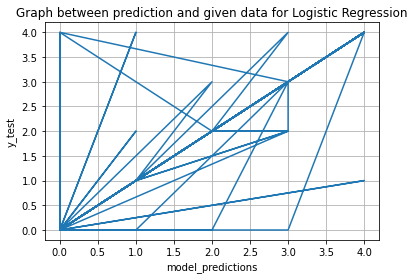

In [33]:
en_random_forest_model = fit_model('random_forest_model')

In [34]:


pickle.dump(en_random_forest_model, open('en_random_forest_model.pkl','wb'))

#### [3.3.3]  Logistic regression model:

Accuracy on test:  0.9899328859060402
Confusion Matrix
[[62  0  0  0  0]
 [ 0 63  0  0  0]
 [ 1  0 52  0  0]
 [ 0  0  1 65  0]
 [ 0  1  0  0 53]]
Classification Report for  LogisticRegression()
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       0.98      1.00      0.99        63
           2       0.98      0.98      0.98        53
           3       1.00      0.98      0.99        66
           4       1.00      0.98      0.99        54

    accuracy                           0.99       298
   macro avg       0.99      0.99      0.99       298
weighted avg       0.99      0.99      0.99       298



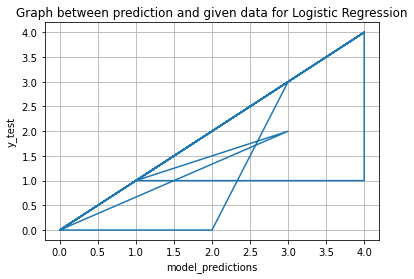

In [35]:
en_logistic_regression_model = fit_model('logistic_regression_model')
pickle.dump(en_logistic_regression_model, open('en_logistic_regression_model.pkl','wb'))

# Step [4]: Test cases:

In [36]:
test_1 ="The term machine learning was coined in 1959 by Arthur Samuel, an American IBMer and pioneer in the field of\
computer gaming and artificial intelligence.[8][9] A representative book of the machine learning research during the 1960s\
was the Nilsson's book on Learning Machines, dealing mostly with machine learning for pattern classification.[10] Interest\
related to pattern recognition continued into the 1970s, as described by Duda and Hart in 1973.[11] In 1981 a report was given\
on using teaching strategies so that a neural network learns to recognize 40 characters (26 letters, 10 digits, and 4 special\
symbols) from a computer terminal.[12] Tomamom M. Mitchell provided a widely quoted, more formal definition of the algorithms\
studied in the machine learning field: A computer program is said to learn from experience E with respect to some class of\
tasks T and performance measure P if its performance at tasks in T, as measured by P, improves with experience E.\
[13] This definition  of the tasks in which machine learning is concerned offers a fundamentally operational definition rather\
than defining the field in cognitive terms. This follows Alan Turing's proposal in his paper Computing Machinery\
and Intelligence, in which the question Can machines think? is replaced with the question Can machines do what we\
(as thinking entities) can do?.[14] Modern day machine learning has two objectives, one is to classify data based on models\
which have been developed, the other purpose is to make predictions for future outcomes based on these model.\
A hypothetical algorithm specific to classifying data may use computer vision of moles coupled with supervised learning\
in order to train it to classify the cancerous moles. Where as, a machine learning algoritihim for stock trading may inform\
the trader of future potential predictions.[15] Artificial intelligence Machine Learning as subfield of AI[16] Part of Machine\
Learning as subfield of AI or part of AI as subfield of Machine Learning[17] As a scientific endeavor, machine learning grew\
out of the quest for artificial intelligence. In the early days of AI as an academic discipline, some researchers were\
interested in having machines learn from data. They attempted to approach the problem with various symbolic methods,\
as well as what was then termed neural networks; these were mostly perceptrons and other models that were later found\
to be reinventions of the generalized linear models of statistics.[18] Probabilistic reasoning was also employed,\
especially in automated medical diagnosis.[19]:488 However, an increasing emphasis on the logical, knowledge-based approach\
caused a rift between AI and machine learning. Probabilistic systems were plagued by theoretical and practical problems\
of data acquisition and representation.[19]:488 By 1980, expert systems had come to dominate AI, and statistics was out of\
favor.[20] Work on symbolic/knowledge-based learning did continue within AI, leading to inductive logic programming,\
but the more statistical line of research was now outside the field of AI proper, in pattern recognition and information\
retrieval.[19]:708–710; 755 Neural networks research had been abandoned by AI and computer science around the same time.\
This line, too, was continued outside the AI/CS field, as connectionism, by researchers from other disciplines including\
Hopfield, Rumelhart and Hinton. Their main success came in the mid-1980s with the reinvention of backpropagation.\
[19]:25 Machine learning (ML), reorganized as a separate field, started to flourish in the 1990s. The field changed its goal\
from achieving artificial intelligence to tackling solvable problems of a practical nature. It shifted focus away from\
the symbolic approaches it had inherited from AI, and toward methods and models borrowed from statistics and probability\
theory.[20] As of 2020, many sources continue to assert that machine learning remains a subfield of AI.[21][22][16] The main\
disagreement is whether all of ML is part of AI, as this would mean that anyone using ML could claim they are using AI.\
Others have the view that not all of ML is part of AI[23][24][25] where only an intelligent subset of ML is part of AI.\
[26] The question to what is the difference between ML and AI is answered by Judea Pearl in The Book of Why.\
[27] Accordingly ML learns and predicts based on passive observations, whereas AI implies an agent interacting with the\
environment to learn and take actions that maximize its chance of successfully achieving its goals.[30]"

In [37]:
summerize_category(test_1, 10, en_random_forest_model)

-------------------------------------------------------------------------------------------------------------------------------
Text summary
-------------------------------------------------------------------------------------------------------------------------------
[8][9] A representative book of the machine learning research during the 1960swas the Nilsson's book on Learning Machines, dealing mostly with machine learning for pattern classification. The term machine learning was coined in 1959 by Arthur Samuel, an American IBMer and pioneer in the field ofcomputer gaming and artificial intelligence. [19]:25 Machine learning (ML), reorganized as a separate field, started to flourish in the 1990s. [20] As of 2020, many sources continue to assert that machine learning remains a subfield of AI. Where as, a machine learning algoritihim for stock trading may informthe trader of future potential predictions. [19]:488 However, an increasing emphasis on the logical, knowledge-based approachc

In [38]:
test_2 = "Founded on 6 March 1902 as Madrid Football Club, the club has traditionally worn a white home kit since inception. \
The word real is Spanish for \"royal\" and was bestowed to the club by King Alfonso XIII in 1920 together with the royal crown\
in the emblem. The team has played its home matches in the 81,044-capacity Santiago Bernabéu Stadium in downtown Madrid since\
1947. Unlike most European sporting entities, Real Madrids members (socios) have owned and operated the club throughout its\
history. The club was estimated to be worth €3.8 billion ($4.2 billion) in 2019, and it was the second highest-earning football\
club in the world, with an annual revenue of €757.3 million in 2019.[7][8] The club is one of the most widely supported teams\
in the world.[9] Real Madrid is one of three founding members of La Liga that have never been relegated from the top division\
since its inception in 1929, along with Athletic Bilbao and Barcelona. The club holds many long-standing rivalries,\
most notably El Clásico with Barcelona and El Derbi with Atlético Madrid. Real Madrid established itself as a major force in\
both Spanish and European football during the 1950s, winning five consecutive European Cups and reaching the final seven times.\
This success was replicated in the league, which the club won five times in the space of seven years. This team, which\
consisted of players Alfredo Di Stéfano, Ferenc Puskás, Francisco Gento, and Raymond Kopa, is considered by some in the sport\
to be the greatest team of all time.[10][11][12] In domestic football, the club has won 66 trophies; a record 34 La Liga\
titles, 19 Copa del Rey, 11 Supercopa de España, a Copa Eva Duarte, and a Copa de la Liga.[13] In European and worldwide\
competitions, Real Madrid have won a record 26 trophies; a record 13 European Cup/UEFA Champions League titles, two UEFA Cups\
and four UEFA Super Cups. In international football, they have achieved a record seven club world championships.[note 1] Real\
Madrid was recognised as the FIFA Club of the 20th Century on 11 December 2000 with 42.35% of the vote,[15] and received\
the FIFA Centennial Order of Merit on 20 May 2004.[16] The club was also awarded Best European Club of the 20th Century by the\
IFFHS on 11 May 2010. In June 2017, the team succeeded in becoming the first club to win consecutive Champions League titles, \
then made it three in a row and four in five seasons in May 2018, extending their lead atop the UEFA club rankings. As of 2020,\
Real Madrid are ranked third behind Bayern Munich and Barcelona.[17][18]"

In [40]:
summerize_category(test_2, 10, en_random_forest_model)

-------------------------------------------------------------------------------------------------------------------------------
Text summary
-------------------------------------------------------------------------------------------------------------------------------
Founded on 6 March 1902 as Madrid Football Club, the club has traditionally worn a white home kit since inception. [16] The club was also awarded Best European Club of the 20th Century by theIFFHS on 11 May 2010. In international football, they have achieved a record seven club world championships. The word real is Spanish for "royal" and was bestowed to the club by King Alfonso XIII in 1920 together with the royal crownin the emblem. [13] In European and worldwidecompetitions, Real Madrid have won a record 26 trophies; a record 13 European Cup/UEFA Champions League titles, two UEFA Cupsand four UEFA Super Cups. [7][8] The club is one of the most widely supported teamsin the world. Unlike most European sporting entities, 